# Configuração de ambiente

Os arquivos de imagem referentes ao treino e teste do Dataset estão armazenados no Google Drive, logo, faz-se necessário uma sincronização com este ambiente do Colab com o Drive para conseguirmos puxar os arquivos para cá.

In [1]:
# !git clone https://github.com/andersonzambeli/ine_410121
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importa-se as diversas bibliotecas que serão necessárias ao decorrer das execuções para treinamento, validação e teste do modelo para reconhcer o estado de semáforos de trânsito e configura-se algumas variáveis relacionadas aos caminhos até os arquivos do Dataset.

In [2]:
import cv2
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import time
from PIL import Image

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

DIR_INPUT = '/content/drive/MyDrive/Testando/Dataset/'
DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"


# Extração das informações sobre os labels e as caixas delimitadoras (bouding box) e o estado dos sinais presentes no arquivo json do Dataset

In [4]:
# Abrindo e coletando os dados do arquivo train.json
with open("/content/drive/MyDrive/Testando/Dataset/train_dataset/train.json") as f:
    data_dict = json.load(f)

# Construindo um dicionário que armazenará todas as informações organizadas dos bouding box
data = []

# Organizando informação dos bouding box para cada anotação
for annotation in data_dict['annotations']:

    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']

    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })


# Transformando o dicionário com as informações separadas e organizadas do arquivo json em um DataFrame do pandas e salvando num arquivo CSV
df = pd.DataFrame(data)
df.to_csv('traffic_lights.csv', index=False)

Reorganizando algumas informações me um dataframe específico para os lables

In [5]:
data_tf = pd.read_csv('/content/traffic_lights.csv')
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('traffic_lights_labels.csv', index=False)
df = pd.read_csv('/content/traffic_lights_labels.csv')
df

,filename,xmin,ymin,xmax,ymax,color
0,00001.jpg,1026.5,741.8,1077.5,910.9,red
1,00002.jpg,1418.7,1136.8,1428.3,1149.4,red
2,00003.jpg,2574.3,868.7,2632.3,887.1,red
3,00003.jpg,2252.1,899.6,2300.8,918.7,green
4,00004.jpg,833.3,1163.2,843.6,1184.8,green
...,...,...,...,...,...,...
9417,03000.jpg,78.8,1001.7,107.7,1033.1,red
9418,03000.jpg,1234.8,1058.4,1251.0,1096.4,green
9419,03000.jpg,1264.9,1068.1,1287.6,1086.1,green
9420,03000.jpg,1296.0,1056.6,1311.7,1096.2,green


# Pequena análise exploratório dos dados presentes no dataset

In [6]:
unq_values = df["filename"].unique()
print("Total de registros: ", len(df))
print("Imagens únicas: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\nNúmero de valores nulos por coluna:")
print(null_values)

Total de registros:  9422
Imagens únicas:  2470

Número de valores nulos por coluna:
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
color       0
dtype: int64


In [7]:
classes = df["color"].unique()
print("Total de Classes registradas: ",len(classes))
print("\nClasses:\n",classes)

Total de Classes registradas:  3

Classes:
 ['red' 'green' 'yellow']


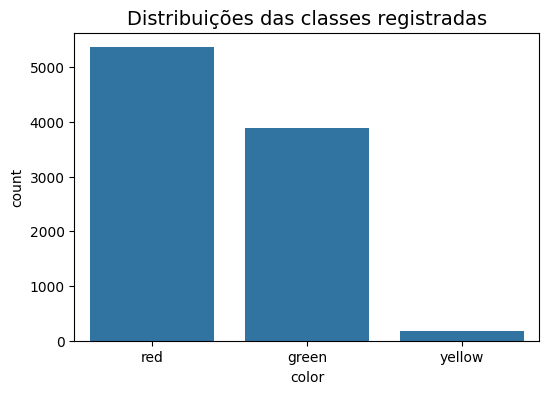

In [9]:
plt.figure(figsize=(6, 4))
plt.title('Distribuições das classes registradas', fontsize= 14)
sns.countplot(x = "color", data = df);

Função para mostrar as imagens originais e com os bounding box anotados/registrados

In [10]:
def plot_img(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

Visualização da imagem original e da anotada

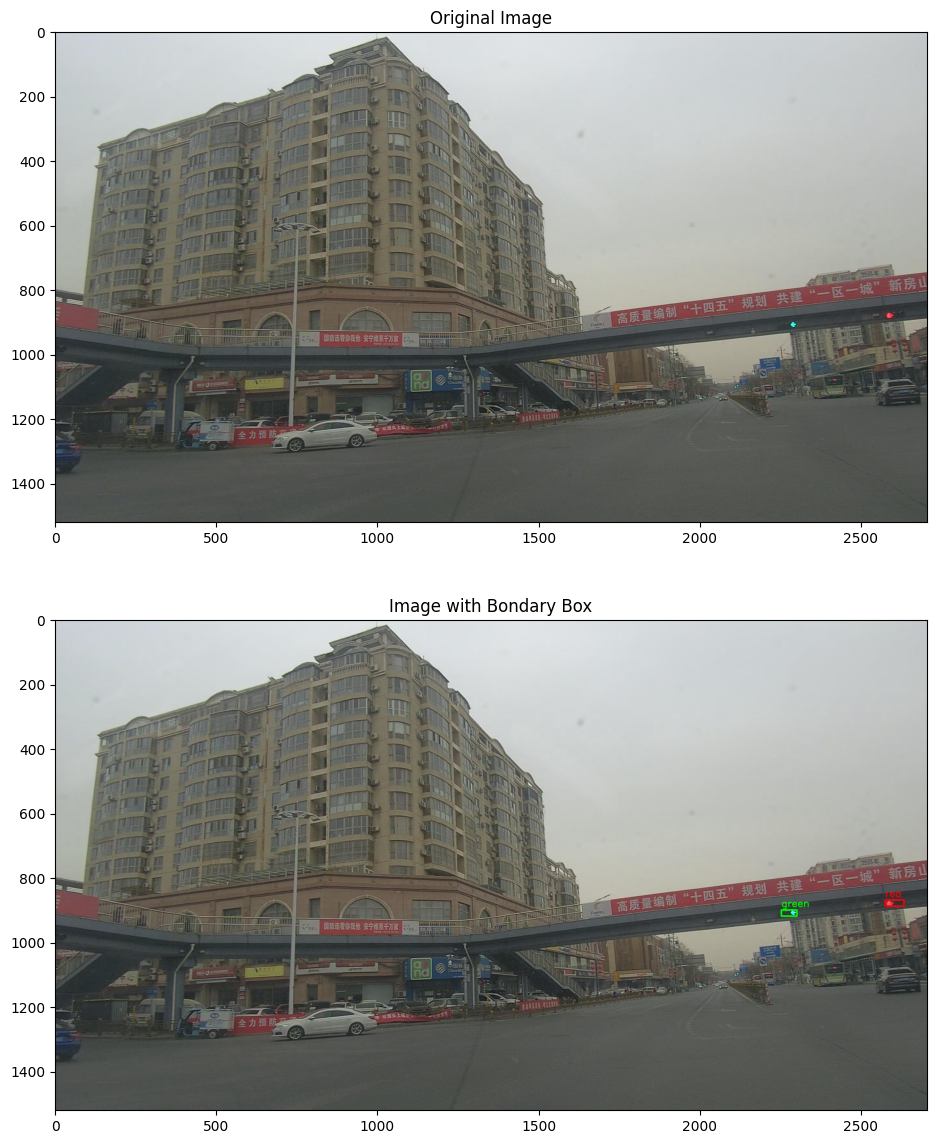

In [11]:
plot_img('00003.jpg')

# Etapa de preparação do Dataset para início do treinamento

In [13]:
_classes = np.insert(classes, 0, "background", axis=0)
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}

In [15]:
# Classe que armazenará o nosso objeto referente ao dataset
class TrafficLightDetectionDataset(Dataset):

    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):

        super().__init__()

        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):

        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]

        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.mode == 'train':

            #Get bounding box co-ordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            #Getting labels for each box
            temp_labels = records[['color']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Resize the image and the bounding boxes
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['area'] = torch.as_tensor(area, dtype=torch.float32)

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name

        elif self.mode == 'test':
            # Resize the image
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))

            if self.transforms:
                image = self.transforms(image)

            return image, image_name


In [24]:

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))

# Instanciando o nosso objeto referente ao dataset
dataset = TrafficLightDetectionDataset(df, DIR_IMAGES, transforms = get_transform())


# Separação do dataset em 80% para compor o treino e os outros 20% para validação/teste
indices = torch.randperm(len(dataset)).tolist()
divisao_20 = int(len(unq_values)*0.2)
train_dataset = torch.utils.data.Subset(dataset, indices[:-divisao_20])
valid_dataset = torch.utils.data.Subset(dataset, indices[-divisao_20:])


# Criação e preparação dos data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [25]:
# Setando a utilização de GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

# Etapa de criação do modelo

(Este modelo será criado do zero, ou seja, não será importado pesos no início do treino)

In [26]:
# Utilizaremos o Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(class_to_int)
# Obtendo número de entradas para as funcionalidades do classificador
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Substituindo a cabeça pré-treinada por uma nova
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [27]:
# Preparando o modelo para treino
params = [p for p in model.parameters() if p.requires_grad] # Organizando todos os parâmetros de treino do modelo para ser usado na construção do otimizador
optimizer = torch.optim.Adam(params, lr = 0.0001) # Criando/definindo otimizador
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # LR
model.to(device)
epochs = 5 # Definindo número de epochs

# Etapa de Treinamento do modelo

In [28]:
itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        # Carregando as imagens e os alvos
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())

        # Resetando gradientes do otimizador
        optimizer.zero_grad()

        # Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        # Adicionando valores da função de perda - Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)

        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n")
        itr += 1
    lr_scheduler.step()

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)

    # Mostrando o progresso na determinada epoch e o tempo percorrido para execução
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed,'\n\n'+'-'*100+'\n\n')

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")

 30%|███       | 301/988 [02:38<04:27,  2.57it/s]


 Iteration #300 loss: 0.8443 



 61%|██████    | 600/988 [05:12<03:10,  2.03it/s]


 Iteration #600 loss: 0.5536 



 91%|█████████ | 901/988 [08:05<00:36,  2.40it/s]


 Iteration #900 loss: 0.8576 



100%|██████████| 988/988 [08:50<00:00,  1.86it/s]


Epoch: 1
Epoch train loss is 0.6788
Time elapsed:  530.8327050209045 

----------------------------------------------------------------------------------------------------




 22%|██▏       | 213/988 [00:26<01:30,  8.56it/s]


 Iteration #1200 loss: 0.4942 



 52%|█████▏    | 513/988 [01:01<00:56,  8.41it/s]


 Iteration #1500 loss: 0.2410 



 82%|████████▏ | 813/988 [01:36<00:20,  8.55it/s]


 Iteration #1800 loss: 0.5159 



100%|██████████| 988/988 [01:56<00:00,  8.45it/s]


Epoch: 2
Epoch train loss is 0.5144
Time elapsed:  116.87114977836609 

----------------------------------------------------------------------------------------------------




 13%|█▎        | 125/988 [00:16<01:41,  8.54it/s]


 Iteration #2100 loss: 0.1781 



 43%|████▎     | 425/988 [00:51<01:06,  8.51it/s]


 Iteration #2400 loss: 0.2791 



 73%|███████▎  | 725/988 [01:26<00:30,  8.51it/s]


 Iteration #2700 loss: 0.4982 



100%|██████████| 988/988 [01:57<00:00,  8.42it/s]


Epoch: 3
Epoch train loss is 0.4179
Time elapsed:  117.34985542297363 

----------------------------------------------------------------------------------------------------




  4%|▎         | 37/988 [00:05<01:51,  8.55it/s]


 Iteration #3000 loss: 0.4025 



 34%|███▍      | 337/988 [00:40<01:16,  8.50it/s]


 Iteration #3300 loss: 0.4127 



 64%|██████▍   | 637/988 [01:15<00:41,  8.47it/s]


 Iteration #3600 loss: 0.1528 



 95%|█████████▍| 937/988 [01:51<00:05,  8.53it/s]


 Iteration #3900 loss: 0.1999 



100%|██████████| 988/988 [01:57<00:00,  8.43it/s]


Epoch: 4
Epoch train loss is 0.3947
Time elapsed:  117.17784667015076 

----------------------------------------------------------------------------------------------------




 25%|██▌       | 249/988 [00:30<01:25,  8.61it/s]


 Iteration #4200 loss: 0.2952 



 56%|█████▌    | 549/988 [01:05<00:51,  8.58it/s]


 Iteration #4500 loss: 0.3967 



 86%|████████▌ | 849/988 [01:41<00:16,  8.61it/s]


 Iteration #4800 loss: 0.4491 



100%|██████████| 988/988 [01:57<00:00,  8.39it/s]


Epoch: 5
Epoch train loss is 0.3769
Time elapsed:  117.74447417259216 

----------------------------------------------------------------------------------------------------




Plotando a função de perda do treino

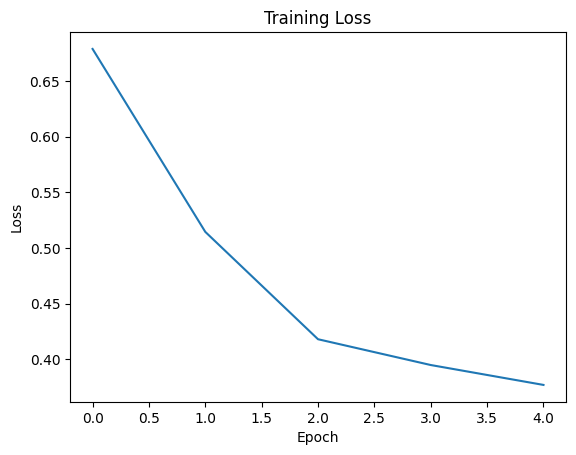

In [29]:
plt.plot(total_train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Etapa de validação/teste do modelo treinado

Obtendo as informações dos arquivos destinados para teste

In [58]:
folder_path = "/content/drive/MyDrive/Testando/Dataset/test_dataset/test_images"

file_names = os.listdir(folder_path)
df_test = pd.DataFrame({'filename': file_names})
df_test

,filename
0,00007.jpg
1,00009.jpg
2,00024.jpg
3,00035.jpg
4,00038.jpg
...,...
395,02950.jpg
396,02956.jpg
397,02965.jpg
398,02974.jpg


In [59]:
unq_values = df_test["filename"].unique()
print("Total de registros: ", len(df_test))
print("Imagens únicas: ",len(unq_values))

Total de registros:  400
Imagens únicas:  400


In [61]:
# submission = pd.DataFrame(columns = ["filename", "xmin", "ymin",
#                                      "xmax", "ymax", "color"])
# submission.head()

# Preferimos usar dicionário na construção ao invés do DataFrame inicialmente proposto
submission = {'filename':[],'xmin':[],'ymin':[],'xmax':[],'ymax':[],'color':[]}

In [63]:
DIR_INPUT = '/content/drive/MyDrive/Testando/Dataset/'
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"

# Preparando as imagens para teste
images = os.listdir(DIR_IMAGES_TEST)
df_test = df_test.drop_duplicates(subset='filename', keep="first")

# Instanciando o objeto referente ao dataset para teste
test_dataset = TrafficLightDetectionDataset(df_test, DIR_IMAGES_TEST, mode = 'test',
                                            transforms = get_transform())

# Data loader para testes
test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [64]:
# Resultados dos testes

threshold = 0.7
model.eval()

for images, image_names in test_data_loader:

    # Forward ->
    images = list(image.to(device) for image in images)
    output = model(images)

    # Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    # Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []

    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])

    for y in range(len(boxes_th)):

        x1 = boxes_th[y][0] * 4
        y1 = boxes_th[y][1] * 4
        x2 = boxes_th[y][2] * 4
        y2 = boxes_th[y][3] * 4
        class_name = labels_th[y]


        # Construindo linha para adição no dicionário
        row = {"filename" : image_names[0],
               "xmin" : x1, "xmax" : x2,
               "ymin" : y1, "ymax" : y2,
               "color" : class_name}

        # Adicionando linha de informações no dicionário
        for key in row:
          submission[key].append(row[key])


In [65]:
submission = pd.DataFrame(submission)
submission

,filename,xmin,ymin,xmax,ymax,color
0,00007.jpg,1336,972,1348,1008,green
1,00007.jpg,1252,976,1268,1008,green
2,00038.jpg,2072,1000,2088,1036,red
3,00038.jpg,672,1076,684,1104,red
4,00069.jpg,1008,880,1024,928,red
...,...,...,...,...,...,...
493,02885.jpg,528,880,588,908,green
494,02885.jpg,116,832,188,860,red
495,02914.jpg,1284,1080,1300,1104,green
496,02914.jpg,1264,1080,1276,1108,red


Gerando um arquivo CSV para armazenar os dados dos resultados

In [66]:
submission.to_csv('submission.csv', index = False)

## Pequena análise exploratória dos dados gerados pelos resultados

In [67]:
df = pd.read_csv('/content/submission.csv')
df.head(10)

,filename,xmin,ymin,xmax,ymax,color
0,00007.jpg,1336,972,1348,1008,green
1,00007.jpg,1252,976,1268,1008,green
2,00038.jpg,2072,1000,2088,1036,red
3,00038.jpg,672,1076,684,1104,red
4,00069.jpg,1008,880,1024,928,red
5,00069.jpg,1064,880,1080,924,red
6,00074.jpg,1152,608,1196,704,green
7,00074.jpg,860,588,904,684,green
8,00074.jpg,1004,596,1040,696,green
9,00092.jpg,1040,940,1064,996,red


In [68]:
DIR_INPUT = '/content/drive/MyDrive/Testando/Dataset/'

DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"

def plot_img_test(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES_TEST, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

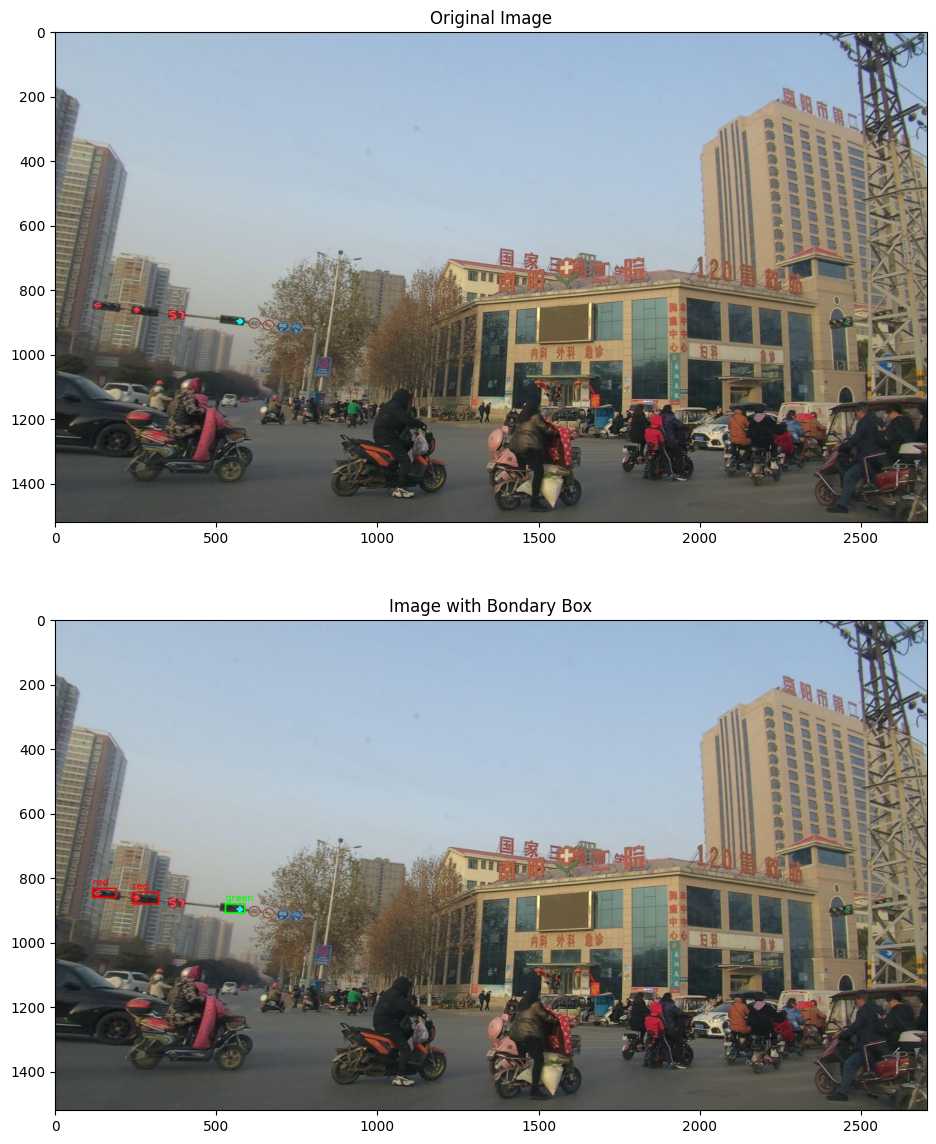

In [73]:
plot_img_test('02885.jpg')